In [120]:
# Add in the neccesary libraries and depedencies
# First precompile takes more time -> Julia creates a underlying type-structure so that it can exploit the JIT feature
using Plots
using Makie
using GraphMakie.NetworkLayout
using CairoMakie
using Tenet
using TensorOperations
using LinearAlgebra
using Graphs
using GraphPlot
using EinExprs
using Combinatorics
using LaTeXStrings
Makie.inline!(true)
include("julia_functions.jl")

SystemError: SystemError: opening file "/home/bart/Desktop/Masterproef /Julia codes/Notebooks with initial implementations/julia_functions.jl": No such file or directory

__The idea:__

Extract from a Tenet.TensorNetwork a high level representation in terms of a Graphs.jl structure which we can reason on to find the nodes and stuff

__Ingriedients of such a mapping:__
- A dictionary which maps the tensors to the vertices?
- A dictionary which maps a tensor index to a edge? 
- How the fuck can an AI reason on this data-structure???? Hahaha

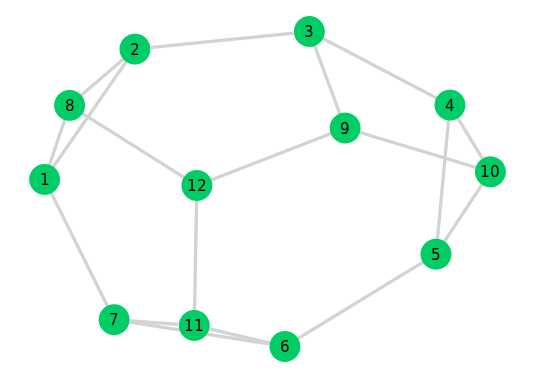

3
2
10
1
3
2
5
10
9
1
6
9
4
1
3
7
4
8


SimpleGraph{Int64}

In [121]:
function fill_with_random(G, dims, visualisation = false, fixed_dim = true)

    """
    Function which takes in a Graphs.jl graph-structure (G) and which generates a Tenet.TensorNetwork based on the connectivity of the network.
    First of all each node is filled with a random tensor, the dims arguement shows the size of each index. Other more complex fill options can be added later down the line
    """
    
    nvertices = nv(G) # number of vertices
    nedges = ne(G)    # number of edges

    nodes = [node for node in vertices(G)]
    edgesgraph = [edge for edge in edges(G)]
    edges_labels = [Symbol(edge) for edge in 1:nedges]
    edges_map = Dict(zip(edgesgraph, edges_labels))

    if visualisation == true
        display(gplot(G, nodelabel=nodes, nodefillc=colorant"springgreen3", layout=spring_layout))
    end


    tensors = []
    # Generating the tensors inside of the network
    for source in vertices(G)
        inds = Tuple([edges_map[edge] for edge in edges(G) if source in([src(edge), dst(edge)])])
        if fixed_dim == true
            size_generation_tuple = Tuple([dims for i in 1:length(inds)])
        end
        if fixed_dim == false
            size_generation_tuple = Tuple([rand(dims[1]:dims[2]) for i in 1:length(inds)])
        end
        push!(tensors, Tensor(rand(size_generation_tuple...), inds))
        
    end

    TN = TensorNetwork(tensors)
    return TN

end


dimension = [1,10]
G = Graphs.smallgraph(:frucht)
tn1 = fill_with_random(G, dimension, true, false)
for ind in inds(tn1)
    println(size(tn1, ind))
end
typeof(G)



In [122]:
function extract_graph_representation(TN, printing=false)

    """
    Function which takes in a TensorNetwork from Tenet.jl, this network only has one edge between two tensors (grouped indices) and no self loops.
    Based on the connectivity inside of the TensorNetwork a simple graph structure is generated.
    For this mapping a dictionary which has vertex labels as keys and corresponding tensors as values is generated.
    For this mapping a dictionary which has the corresponding edge as keys and as values the corresponding tensors indices.
    A fully weighted edge list is generated [[source, drain, size], ...]
    An edge to index map is generated Dict[(source, drain)] -> Tensor network index
    """

    n_vertices = length(tensors(TN))
    n_edges =  [[inds(tensor)...] for tensor in tensors(TN)]
    to_set = []
    for group in n_edges
        for element in group
            push!(to_set, element)
        end
    end
    n_edges = length(Set(to_set))
    
    if printing == true
        println("Amount of extracted vertices = ", n_vertices, "\nAmount of extracted edges = ", n_edges)
    end

    list_of_edges = collect((Set(to_set)))
    tensor_vertex_map = Dict{Int, Tenet.Tensor}()  # Specify the type of the keys and values
    for (i, tensor) in enumerate(tensors(TN))
        tensor_vertex_map[Int(i)] = tensor
    end

    if printing == true
        println(tensor_vertex_map)
    end

    g = SimpleGraph(n_vertices)
    nodes = [node for node in vertices(g)]

    # the connectivty inside of the tensor network should be mapped onto the connectivty of the SimpleGraph
    index_edge_map = Dict{}()

    fully_weighted_edge_list = []                                               # generate a list containing the weighted edges [source, drain, size]
    edge_index_map = Dict{}()                                                   # dictionary which maps (source, drain) tuples to tensor network indices

    pairs = collect(combinations([node for node in vertices(g)], 2))
    for possible_connection in pairs
        v1 = possible_connection[1]
        v2 = possible_connection[2]
        T_v1 = tensor_vertex_map[v1]
        T_v2 = tensor_vertex_map[v2]
        # connectivity measure
        index_intersection =  intersect(inds(T_v1), inds(T_v2))
        if length(index_intersection) == 1
            add_edge!(g, v1, v2)
            edge = [edge for edge in edges(g) if [src(edge), dst(edge)] == possible_connection][1]
            index_edge_map[index_intersection] = edge
            push!(fully_weighted_edge_list, Array([v1, v2, size(TN, index_intersection[1])]))
            edge_index_map[(v1,v2)] = index_intersection
        end
    end

    if printing == true
        display(gplot(g, nodelabel=[node for node in vertices(g)]))
        println(index_edge_map)
    end

    return g, tensor_vertex_map, index_edge_map, fully_weighted_edge_list, edge_index_map

end


function sized_adj_from_weightededges(fully_weighted_edge_list, graph)
    # Define the number of vertices in the graph
    num_vertices = nv(graph)

    # Initialize a sized adjacency matrix with zeros
    sized_adj_matrix = zeros(Int, num_vertices, num_vertices)

    # Add edges to the adjacency matrix with specified sizes
    for weighted_edge in fully_weighted_edge_list
        u = weighted_edge[1]
        v = weighted_edge[2]
        size = weighted_edge[3]
        # Modify the matrix
        sized_adj_matrix[u, v] = size
        sized_adj_matrix[v, u] = size  # Add reverse edge to ensure symmetry
    end

    return sized_adj_matrix
end 



function graph_to_tensornetwork(graph_structure, tensors_dict, edges_dict)

    """
    Function which takes in a SimpleGraph from Graphs.jl, this network only has one edge between two tensors (grouped indices) and no self loops.
    Based on the connectivity inside of the SimpleGraph a corresponding tensor_network structure is generated.
    For this mapping a dictionary is used which has vertex labels as keys and corresponding tensors as values.
    For this mapping a dictionary is used which has the corresponding edge as keys and as values the corresponding tensors indices.
    """
    tensors = values(tensors_dict)
    TN = TensorNetwork(tensors)
    return TN

end


graph_to_tensornetwork (generic function with 1 method)

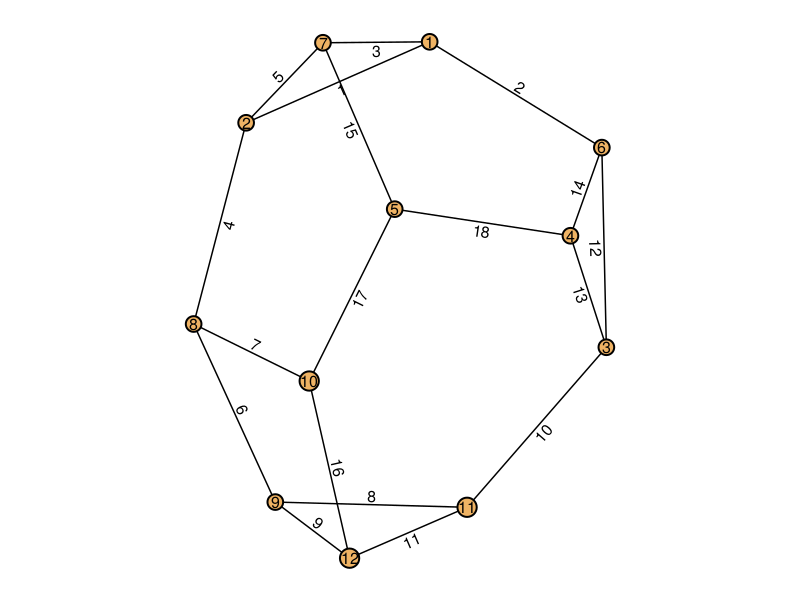

Vector{Any}
fully weighted edge list
Any[[1, 2, 1], [1, 6, 10], [1, 7, 9], [2, 7, 1], [2, 8, 7], [3, 4, 2], [3, 6, 1], [3, 11, 10], [4, 5, 3], [4, 6, 9], [5, 7, 4], [5, 10, 3], [8, 9, 4], [8, 10, 2], [9, 11, 6], [9, 12, 5], [10, 12, 3], [11, 12, 8]]
edge->index mapping
Dict{Any, Any}((4, 5) => [Symbol("18")], (1, 2) => [Symbol("1")], (4, 6) => [Symbol("14")], (11, 12) => [Symbol("11")], (9, 12) => [Symbol("9")], (8, 9) => [Symbol("6")], (3, 4) => [Symbol("13")], (2, 7) => [Symbol("5")], (2, 8) => [Symbol("4")], (5, 7) => [Symbol("15")], (1, 6) => [Symbol("2")], (9, 11) => [Symbol("8")], (10, 12) => [Symbol("16")], (3, 11) => [Symbol("10")], (5, 10) => [Symbol("17")], (1, 7) => [Symbol("3")], (3, 6) => [Symbol("12")], (8, 10) => [Symbol("7")])


18-element BitVector:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [123]:
display(Makie.plot(tn1, labels=true, ilabels=[string(number) for number in 1:length(tensors(tn1))]))

graph, tensordict, edgesdict, fully_weighted_edge_list, edge_index_map = extract_graph_representation(tn1, false)
println(typeof(fully_weighted_edge_list))
println("fully weighted edge list")
println(fully_weighted_edge_list)
println("edge->index mapping")
println(edge_index_map)


# adj_matrix = adjacency_matrix(graph)
# laplacian = laplacian_matrix(graph)
# vals  = eigvals(Matrix{Float64}(laplacian))
# n_spanning = 1/12*prod([vals[i] for i in 2:12])
# println("number of spanning trees = ", n_spanning)
# display(adj_matrix)
# display(sized_adj_from_weightededges(fully_weighted_edge_list, graph))

# Based on the graph_structure extract the relevant action mask
# --> EDGE AVAILABILITY FUNCTION
function cycle_basis_to_edges(cycle_basis)

    edges = []

    for cycle in cycle_basis
        # extract the edges from the current cycle
        c_edges = [[cycle[i], cycle[i+1]] for i in 1:length(cycle)-1]
        push!(c_edges, [cycle[end], cycle[1]])
        # add the sorted edge to the edges if not already inside of edges
        for edge in c_edges
            if sort(edge) in edges                                              
                continue
            end
            push!(edges, sort(edge))
        end
    end
   
    return sort(edges)
end


function update_edge_availability(graph, fully_weighted_edge_list, boolean_edge_availability)

    """
    Function which takes in a freshly modified Graphs.jl structure, 
    a fully_weighted_edge_list, a current boolean_edge_availability list and
    this functions updates the boolean_edge_availability list based on the
    current graph structure (after removing an edge)
    """

    # Get the cycle_basis of the graph which represent all the simple cycles
    cycles = cycle_basis(graph)                                                 # Use the current graph structure to extract relevant information
    cycle_edges = cycle_basis_to_edges(cycles)                                  # extract a list of the possible available [source, drain] combinations

    # For each list in the fully_weighted_edge_list 
    # update the boolean_edge_availability list based on if this specific edge
    # is inside of the cycle_edges
    for (i, edge_weight) in enumerate(fully_weighted_edge_list)
        edge = edge_weight[1:2]
        if edge ∈ cycle_edges
            boolean_edge_availability[i] = true
        else
            boolean_edge_availability[i] = false
        end
    end
    
    return boolean_edge_availability

end


boolean_edge_availability = trues(length(fully_weighted_edge_list))
update_edge_availability(graph, fully_weighted_edge_list, boolean_edge_availability)

